# 用NNF进行滤波的一个展示

# A demo for evaluting the NNF filtering performance

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchsummary import summary
import pickle
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy.fft as fft
from FilterNet_utils import ConvBNReLU, pooling1d, global_average_pooling1d, Filter5, read_pickle_to_array, Data_set, training_1, \
    training_2, array_to_tensor

def compute_snr(pure_signal, noisy_signal): #SNR
    signal_to_noise_ratio = 10 * (np.log10(np.std(pure_signal)/np.std(pure_signal-noisy_signal)))
    return signal_to_noise_ratio

def smoothing(array, threshold=0.5):
    anomaly_indices = np.where(array < threshold) #当条件成立时，where返回的是每个符合condition条件元素的坐标,返回的是以元组的形式
    array = np.delete(array, anomaly_indices)
    return array


def smoothing_n_comparision(array, label, threshold=0.5):
    anomaly_indices = np.where(array < threshold)
    array = np.delete(array, anomaly_indices)
    label = np.delete(label, anomaly_indices)
    return array, label

def fourier_transform(sample, mode="p"):
    if mode == "p":
        N = len(sample)  # 1111
        sample_ft = fft.fft(sample)  # 信号的傅里叶变换 (复数)
        frequencies = fft.fftfreq(sample_ft.size, 1/N)  # 傅里叶变换后的每种频率分量的频率值
        amplitude = np.abs(sample_ft)  # 傅里叶变换的振幅
        p = 20*np.log10(amplitude)
        frequency = frequencies[frequencies > 0]
        p = p[frequencies > 0]
        return p, frequency
    elif mode == "a":
        N = len(sample)  # 1111
        sample_ft = fft.fft(sample)  # 信号的傅里叶变换 (复数)
        frequencies = fft.fftfreq(sample_ft.size, 1 / N)  # 傅里叶变换后的每种频率分量的频率值
        amplitude = np.abs(sample_ft)  # 傅里叶变换的振幅
        frequency = frequencies[frequencies > 0]
        amplitude = amplitude[frequencies > 0]
        return amplitude, frequency

In [6]:
no_noise_path = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\深度学习滤波器/CH_nonoise_spectral.npy"
CH4_no_noise_spectral = np.load(no_noise_path)  # (1000, 1111) 透射谱（吸收谱）
noisy_path = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\深度学习滤波器/CH_noisy_spectral.npy"
CH4_noisy_spectral = np.load(noisy_path)  # (1000, 1111) 透射谱（吸收谱）

input_data = CH4_noisy_spectral
label_data = CH4_no_noise_spectral
# input_data = input_data[:, np.newaxis]  # (1000,1,1111)，np.newaxis的作用就是增加一个新的维度

print("input_data shape: ",input_data.shape)
print("CH4_noisy_spectral shape: ",CH4_noisy_spectral.shape)

"""转化为torch类型"""
#input_data
CH4_noisy_spectral = torch.from_numpy(input_data)
CH4_noisy_spectral = CH4_noisy_spectral.type(torch.cuda.FloatTensor)
#label_data
CH4_no_noise_spectral = torch.from_numpy(label_data)
CH4_no_noise_spectral = CH4_no_noise_spectral.type(torch.cuda.FloatTensor)

print("CH4_noisy_spectral.shape", CH4_noisy_spectral .shape)
print("CH4_no_noise_spectral.shape", CH4_no_noise_spectral.shape)


#从样本总和中抽取几个

sample3 = CH4_noisy_spectral[600]
sample3 = sample3.reshape((1,1111))


CH4_no_noise_spectral = np.squeeze(CH4_no_noise_spectral.cpu().numpy())
Gpu = torch.device("cuda")

input_data shape:  (1000, 1111)
CH4_noisy_spectral shape:  (1000, 1111)
CH4_noisy_spectral.shape torch.Size([1000, 1111])
CH4_no_noise_spectral.shape torch.Size([1000, 1111])


In [10]:
#加载模型
Gpu = torch.device("cuda")
model = Filter5().to(Gpu)
model_save_path = r"D:\PYHTON\python3.7\DeepLearningProgram\科研项目\深度学习滤波器\滤波模型\透射谱的滤波模型\DNN_filter2.pt"
model.load_state_dict(torch.load(model_save_path))
model.eval()

Filter5(
  (fc1): Linear(in_features=1111, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=1111, bias=True)
)

sample3.shape torch.Size([1, 1, 1, 1, 1, 1, 1111])
restored31: (1111,)
CH4_no_noise_spectral.shape (1111,)


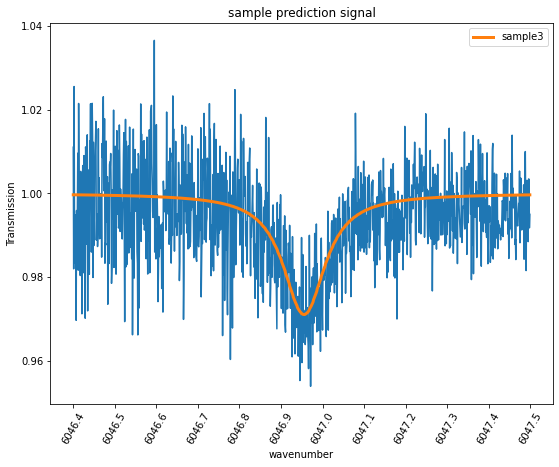

In [16]:
sample3 = sample3.to(Gpu)
print("sample3.shape", sample3.shape)
sample3 = torch.unsqueeze(sample3, 0)
restored3 = model(sample3)
restored3 = np.squeeze(restored3.cpu().detach().numpy())

print("restored31:",restored3.shape)#(1111,)
pure_signal = CH4_no_noise_spectral[600]
print("CH4_no_noise_spectral.shape", pure_signal.shape)

restored3 = smoothing(restored3)

#第二张图片
plt.figure(figsize=(9,7))
x_list = np.arange(6046.4, 6047.5, (6047.5 - 6046.4) / 1111)
x_list1 = np.arange(6046.4, 6047.5, 0.1)
plt.title("sample prediction signal")
plt.plot(x_list, np.squeeze(sample3.cpu().detach().numpy()))
plt.plot(x_list,restored3,label="sample3", linewidth=3)
plt.xticks(x_list1, rotation=60)
plt.xlabel('wavenumber')
plt.ylabel('Transmission')
plt.legend()
plt.show()